# Software Development Queue Simulation

This notebook demonstrates software development workflow simulation using SimPy, a process-based discrete-event simulation framework. The simulation models different development approaches to analyze their impact on team productivity and lead times.

In [114]:
# Import Required Libraries
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass, field
from typing import List, Dict, Any
from datetime import datetime, timedelta
import random

# Set random seed for reproducible results
random.seed(42)
np.random.seed(42)

print("Libraries imported successfully")
print(f"SimPy version: {simpy.__version__}")

Libraries imported successfully
SimPy version: 4.1.1


## Simulation Configuration

Configure key parameters for the simulation including defect rates and improvement factors.

In [ ]:
# Simulation Configuration Variables
# ===================================

# Base defect rate (probability that a PR will receive feedback requiring changes)
BASE_DEFECT_RATE = 0.75  # 75% of PRs get some kind of feedback in traditional development

# Improvement factors (multiplicative reductions to base defect rate)
PAIR_DEFECT_REDUCTION_FACTOR = 0.60  # Pair programming reduces defect rate by 40% (75% → 45%)

# When both AI and pairing are used, effects stack multiplicatively
# Example: 0.75 * 0.85 * 0.60 = ~38% defect rate for AI-enhanced pairs

print(f"Configuration loaded:")
print(f"  Base defect rate: {BASE_DEFECT_RATE:.1%}")
print(f"  Pair reduction factor: {PAIR_DEFECT_REDUCTION_FACTOR:.2f} ({(1-PAIR_DEFECT_REDUCTION_FACTOR):.0%} reduction)")
print(f"  Pair programming defect rate: {BASE_DEFECT_RATE * PAIR_DEFECT_REDUCTION_FACTOR:.1%}")

Configuration loaded:
  Base defect rate: 75.0%
  AI reduction factor: 0.85 (15% reduction)
  Pair reduction factor: 0.60 (40% reduction)
  AI-enhanced defect rate: 63.7%
  Pair programming defect rate: 45.0%
  AI-enhanced pairs defect rate: 38.2%


## Core Data Classes

Data structures for modeling tickets and developers in the simulation.

In [ ]:
@dataclass
class Ticket:
    """Ticket class for simulation tracking"""
    id: int
    created_at: float  # Simulation time
    completed_at: float = None
    rework_cycles: int = 0
    total_rework_time: float = 0.0
    pr_queue_time: float = 0.0  # Time spent waiting in PR queue
    needs_rework: bool = False  # Flag to track if ticket needs rework
    assigned_developer_id: int = None  # Track which developer owns this ticket
    
    @property
    def lead_time_hours(self) -> float:
        """Calculate lead time in hours"""
        if self.completed_at is None:
            return 0.0
        return self.completed_at - self.created_at

@dataclass
class Developer:
    """Developer configuration"""
    id: int
    name: str
    is_ai_enhanced: bool = False
    is_pair: bool = False
    
    @property
    def coding_speed_multiplier(self) -> float:
        return 1.3 if self.is_ai_enhanced else 1.0
    
    @property
    def defect_rate(self) -> float:
        """Calculate defect rate based on developer configuration and global settings"""
        rate = BASE_DEFECT_RATE
        
        if self.is_pair:
            rate *= PAIR_DEFECT_REDUCTION_FACTOR
            
        return rate

print("Core classes defined")

Core classes defined


## Queue Simulation Engine

The main simulation engine that manages the discrete event simulation process.

In [117]:
class EnhancedQueueSimulation:
    """Queue simulation engine using SimPy discrete event simulation"""
    
    def __init__(self, scenario_name: str, max_rework_cycles: int = 10):
        self.scenario_name = scenario_name
        self.env = simpy.Environment()
        
        # SimPy Resources (queues with capacity)
        self.pr_review_queue = simpy.Resource(self.env, capacity=1)  # 1 reviewer available
        
        # Data collection
        self.completed_tickets: List[Ticket] = []
        self.daily_metrics: List[Dict] = []
        self.ticket_counter = 0
        
        # Track tickets needing rework by developer
        self.rework_queue: Dict[int, List[Ticket]] = {}  # developer_id -> list of tickets needing rework
        
        # Simulation parameters
        self.hours_per_day = 8
        self.max_rework_cycles = max_rework_cycles
        
        # Track developer states for concurrent work
        self.developer_current_work = {}  # Track what each developer is working on
        
    def create_ticket(self, developer_id: int) -> Ticket:
        """Create a new ticket assigned to a developer"""
        self.ticket_counter += 1
        ticket = Ticket(id=self.ticket_counter, created_at=self.env.now, assigned_developer_id=developer_id)
        return ticket
    
    def check_for_defects(self, developer: Developer) -> bool:
        """Check if ticket has defects based on developer defect rate"""
        return random.random() < developer.defect_rate
    
    def calculate_rework_time(self, base_time: float, developer: Developer) -> float:
        """Calculate rework time with realistic distribution: mostly small fixes, occasional large ones"""
        
        # Generate a random rework complexity factor
        # 70% chance: small fixes (5-15% of original work)
        # 20% chance: medium fixes (20-40% of original work)  
        # 10% chance: large fixes (50-80% of original work)
        rand = random.random()
        
        if rand < 0.7:
            # Small fixes: typos, formatting, simple variable renames
            rework_factor = random.uniform(0.05, 0.15)  # 5-15% of original
        elif rand < 0.9:
            # Medium fixes: logic changes, refactoring methods
            rework_factor = random.uniform(0.20, 0.40)  # 20-40% of original
        else:
            # Large fixes: architectural changes, major rewrites
            rework_factor = random.uniform(0.50, 0.80)  # 50-80% of original
        
        rework_time = base_time * rework_factor
        
        total_rework_time = rework_time
        # Context switching penalty only applies to non-pairs
        if not developer.is_pair:
            context_switch_penalty = 0.5  # 30 minutes context switching
            total_rework_time += context_switch_penalty
        
        if developer.is_ai_enhanced:
            total_rework_time = total_rework_time / developer.coding_speed_multiplier
            
        return total_rework_time
    
    def development_process(self, ticket: Ticket, developer: Developer, base_hours: float):
        """Development work process - only handles initial coding"""
        # Initial development (no defect checking here)
        actual_dev_time = base_hours / developer.coding_speed_multiplier
        yield self.env.timeout(actual_dev_time)
        # No rework cycles here - they happen during PR review
    
    def pr_review_process(self, ticket: Ticket, developer: Developer) -> bool:
        """
        Process for a single PR review. Returns True if defects are found, False otherwise.
        This process acquires a reviewer, performs the review, and releases the reviewer.
        """
        # Request PR review resource
        with self.pr_review_queue.request() as request:
            queue_start = self.env.now
            yield request  # Wait for reviewer to be available
            
            # Track queue wait time (this will accumulate over multiple reviews)
            ticket.pr_queue_time += self.env.now - queue_start
            
            # PR review takes 20 minutes
            review_time = 20/60  # 20 minutes in hours
            yield self.env.timeout(review_time)
            
            # During review, defects might be discovered
            return self.check_for_defects(developer)

    def developer_workflow(self, developer: Developer, simulation_days: int):
        """Continuous workflow for a developer with proper rework handling"""
        # Initialize rework queue for this developer
        if developer.id not in self.rework_queue:
            self.rework_queue[developer.id] = []
            
        tickets_in_review = []  # Track tickets currently in PR review
        
        # Each developer continuously picks up work for the simulation period
        while self.env.now < simulation_days * self.hours_per_day:
            # Clean up completed tickets
            tickets_in_review = [t for t in tickets_in_review if t.completed_at is None]
            
            # Priority 1: Check for tickets needing rework
            if self.rework_queue[developer.id]:
                ticket = self.rework_queue[developer.id].pop(0)  # Get first ticket needing rework
                ticket.needs_rework = False
                
                # Do rework
                rework_time = self.calculate_rework_time(8.0, developer)
                ticket.total_rework_time += rework_time
                yield self.env.timeout(rework_time)
                
                # Re-submit for review
                self.env.process(self.handle_pr_review_resubmit(ticket, developer))
                tickets_in_review.append(ticket)
                continue
            
            # Priority 2: If no rework, start new work (developers can work while waiting for PR feedback)
            ticket = self.create_ticket(developer.id)
            tickets_in_review.append(ticket)
            
            # Do the initial development work
            yield self.env.process(self.development_process(ticket, developer, 8.0))
            
            if not developer.is_pair:  # Only PR scenarios use review queue
                # Submit to PR review queue
                self.env.process(self.handle_pr_review_initial(ticket, developer))
            else:
                # Pairs commit directly
                self.env.process(self.handle_pair_commit(ticket, developer))
                tickets_in_review.remove(ticket)
            continue
        
        # Wait for any remaining work to complete
        while tickets_in_review or self.rework_queue[developer.id]:
            yield self.env.timeout(0.1)  # Small delay to prevent busy waiting
            tickets_in_review = [t for t in tickets_in_review if t.completed_at is None]
    
    def handle_pr_review_initial(self, ticket: Ticket, developer: Developer):
        """Handle initial PR submission"""
        # Submit for review
        defects_found = yield self.env.process(self.pr_review_process(ticket, developer))
        
        if defects_found and ticket.rework_cycles < self.max_rework_cycles:
            ticket.rework_cycles += 1
            ticket.needs_rework = True
            # Add to developer's rework queue
            self.rework_queue[developer.id].append(ticket)
        else:
            # No defects or max rework reached - ticket is complete
            ticket.completed_at = self.env.now
            self.completed_tickets.append(ticket)
    
    def handle_pr_review_resubmit(self, ticket: Ticket, developer: Developer):
        """Handle PR resubmission after rework"""
        # Submit for review again
        defects_found = yield self.env.process(self.pr_review_process(ticket, developer))
        
        if defects_found and ticket.rework_cycles < self.max_rework_cycles:
            ticket.rework_cycles += 1
            ticket.needs_rework = True
            # Add back to developer's rework queue
            self.rework_queue[developer.id].append(ticket)
        else:
            # No defects or max rework reached - ticket is complete
            ticket.completed_at = self.env.now
            self.completed_tickets.append(ticket)
    
    def handle_pr_review(self, ticket: Ticket, developer: Developer):
        """
        Handle the full PR review lifecycle, including rework and re-queuing.
        A ticket will loop through review -> rework -> re-queue until it passes.
        """
        has_defects = True
        while has_defects and ticket.rework_cycles < self.max_rework_cycles:
            # Submit for review and wait for the outcome
            defects_found = yield self.env.process(self.pr_review_process(ticket, developer))
            
            if defects_found:
                ticket.rework_cycles += 1
                
                # Developer does rework
                rework_time = self.calculate_rework_time(8.0, developer)
                ticket.total_rework_time += rework_time
                yield self.env.timeout(rework_time)
                
                # After rework, the loop continues, and it will be re-queued for review
                has_defects = True
            else:
                # No defects found, the process is complete
                has_defects = False
        
        # Ticket is now complete
        ticket.completed_at = self.env.now
        self.completed_tickets.append(ticket)
    
    def handle_pair_commit(self, ticket: Ticket, developer: Developer):
        """Handle pair programming commit with potential post-commit rework"""
        # Initial commit - small delay for CI/CD pipeline
        yield self.env.timeout(0.1)  # 6 minutes for automated tests
        
        # Check if defects are discovered after commit (build breaks, tests fail)
        has_defects = self.check_for_defects(developer)
        
        # If defects found, enter rework cycle (similar to PR review but immediate)
        while has_defects and ticket.rework_cycles < self.max_rework_cycles:
            ticket.rework_cycles += 1
            
            # Pair does immediate rework (no context switching penalty since they're still on the same task)
            rework_time = self.calculate_rework_time(8.0, developer)  # Use original base_hours
            ticket.total_rework_time += rework_time
            
            yield self.env.timeout(rework_time)
            
            # Re-test/re-deploy (minimal delay)
            yield self.env.timeout(0.1)  # 6 minutes for re-testing
            
            # Check if rework introduces new defects (half the normal rate)
            rework_defect_rate = developer.defect_rate / 2
            if random.random() < rework_defect_rate:
                has_defects = True  # New defects found, continue cycle
            else:
                has_defects = False  # Rework successful, exit cycle
        
        # Ticket is now complete
        ticket.completed_at = self.env.now
        self.completed_tickets.append(ticket)
    
    def daily_metrics_collector(self):
        """Collect daily metrics"""
        day = 0
        while True:
            yield self.env.timeout(self.hours_per_day)  # Wait one day
            day += 1
            
            # Calculate daily metrics
            total_completed = len(self.completed_tickets)
            if total_completed > 0:
                avg_lead_time = sum(t.lead_time_hours for t in self.completed_tickets) / total_completed
                avg_rework_cycles = sum(t.rework_cycles for t in self.completed_tickets) / total_completed
            else:
                avg_lead_time = 0
                avg_rework_cycles = 0
            
            self.daily_metrics.append({
                'day': day,
                'scenario': self.scenario_name,
                'total_completed': total_completed,
                'avg_lead_time_hours': avg_lead_time,
                'avg_rework_cycles': avg_rework_cycles,
                'simulation_time': self.env.now
            })

print("Simulation engine ready")

Simulation engine ready


## Scenario Implementations

Different workflow scenarios for comparison: traditional PR, AI-enhanced, pair programming, and AI-enhanced pairs.

In [118]:
class TraditionalPRScenario(EnhancedQueueSimulation):
    """Traditional PR workflow simulation"""
    
    def __init__(self):
        super().__init__("Traditional PR")
        self.developers = [Developer(i, f"Dev{i}") for i in range(1, 8)]  # 7 developers (1 is reviewing)
    
    def run_simulation(self, days: int = 30) -> Dict[str, Any]:
        """Run the simulation with continuous workflow"""
        # Start daily metrics collection
        self.env.process(self.daily_metrics_collector())
        
        # Start continuous workflow for each developer
        for dev in self.developers:
            self.env.process(self.continuous_workflow(dev, days))
        
        # Run simulation with consistent buffer time for all scenarios
        self.env.run(until=(days + 2) * self.hours_per_day)
        
        return self.get_summary_metrics()
    
    def continuous_workflow(self, developer: Developer, total_days: int):
        """Developer continuously picks up new tickets with proper PR workflow"""
        # Use the new developer_workflow that handles concurrent tickets and context switching
        yield self.env.process(self.developer_workflow(developer, total_days))
    
    def delayed_ticket_start(self, developer: Developer, start_time: float, base_hours: float):
        """Start a ticket at a specific time"""
        yield self.env.timeout(start_time - self.env.now)
        yield self.env.process(self.ticket_lifecycle(developer, base_hours))
    
    def get_summary_metrics(self) -> Dict[str, Any]:
        """Calculate summary metrics"""
        if not self.completed_tickets:
            return {'scenario': self.scenario_name, 'total_tickets': 0, 'avg_lead_time_hours': 0}
        
        return {
            'scenario': self.scenario_name,
            'total_tickets': len(self.completed_tickets),
            'avg_lead_time_hours': sum(t.lead_time_hours for t in self.completed_tickets) / len(self.completed_tickets),
            'avg_rework_cycles': sum(t.rework_cycles for t in self.completed_tickets) / len(self.completed_tickets),
            'avg_pr_queue_time': sum(t.pr_queue_time for t in self.completed_tickets) / len(self.completed_tickets),
            'total_rework_time': sum(t.total_rework_time for t in self.completed_tickets)
        }

class AIEnhancedPRScenario(TraditionalPRScenario):
    """AI-Enhanced PR workflow"""
    
    def __init__(self):
        super().__init__()
        self.scenario_name = "AI-Enhanced PR"
        # Convert developers to AI-enhanced
        self.developers = [Developer(i, f"AIdev{i}", is_ai_enhanced=True) for i in range(1, 8)]  # 7 developers (1 is reviewing)

class PairProgrammingScenario(EnhancedQueueSimulation):
    """Pair programming workflow (no PR queue)"""
    
    def __init__(self):
        super().__init__("Pair Programming")
        # 4 pairs of developers
        self.developers = [Developer(i, f"Pair{i}", is_pair=True) for i in range(1, 5)]
    
    def run_simulation(self, days: int = 30) -> Dict[str, Any]:
        """Run pair programming simulation with continuous workflow"""
        self.env.process(self.daily_metrics_collector())
        
        # Start continuous workflow for each pair
        for dev in self.developers:
            self.env.process(self.continuous_workflow(dev, days))
        
        # Add buffer time for completion
        self.env.run(until=(days + 2) * self.hours_per_day)
        return self.get_summary_metrics()
    
    def continuous_workflow(self, developer: Developer, total_days: int):
        """Pair continuously picks up new tickets (no PR queue, immediate completion)"""
        # Use the new developer_workflow that handles the pair programming flow
        yield self.env.process(self.developer_workflow(developer, total_days))
    
    def delayed_ticket_start(self, developer: Developer, start_time: float, base_hours: float):
        yield self.env.timeout(start_time - self.env.now)
        yield self.env.process(self.ticket_lifecycle(developer, base_hours))
    
    def get_summary_metrics(self) -> Dict[str, Any]:
        if not self.completed_tickets:
            return {'scenario': self.scenario_name, 'total_tickets': 0, 'avg_lead_time_hours': 0}
        
        return {
            'scenario': self.scenario_name,
            'total_tickets': len(self.completed_tickets),
            'avg_lead_time_hours': sum(t.lead_time_hours for t in self.completed_tickets) / len(self.completed_tickets),
            'avg_rework_cycles': sum(t.rework_cycles for t in self.completed_tickets) / len(self.completed_tickets),
            'avg_pr_queue_time': 0,  # No PR queue for pairs
            'total_rework_time': sum(t.total_rework_time for t in self.completed_tickets)
        }

class AIEnhancedPairScenario(PairProgrammingScenario):
    """AI-Enhanced pair programming"""
    
    def __init__(self):
        super().__init__()
        self.scenario_name = "AI-Enhanced Pairs"
        self.developers = [Developer(i, f"AIPair{i}", is_ai_enhanced=True, is_pair=True) for i in range(1, 5)]

print("All scenario classes defined")

All scenario classes defined


## Run Simulation

Execute all scenarios and collect results.

In [119]:
# Run all scenarios
print("Running simulation...")

scenarios = [
    TraditionalPRScenario(),
    AIEnhancedPRScenario(), 
    PairProgrammingScenario(),
    AIEnhancedPairScenario()
]

results = []
detailed_data = []

for scenario in scenarios:
    print(f"Running {scenario.scenario_name}...")
    result = scenario.run_simulation(days=60)  # 1 quarter = 60 business days
    results.append(result)
    
    print(f"  Completed: {result['total_tickets']} tickets")
    print(f"  Avg lead time: {result['avg_lead_time_hours']:.1f}h")
    
    # Collect detailed daily data
    for metric in scenario.daily_metrics:
        detailed_data.append(metric)

print("\nSimulation complete!")

Running simulation...
Running Traditional PR...
  Completed: 246 tickets
  Avg lead time: 23.1h
Running AI-Enhanced PR...
  Completed: 380 tickets
  Avg lead time: 15.1h
Running Pair Programming...
  Completed: 240 tickets
  Avg lead time: 9.0h
Running AI-Enhanced Pairs...
  Completed: 316 tickets
  Avg lead time: 7.0h

Simulation complete!


## Results Analysis and Visualization

Comprehensive analysis and visualization of simulation results.

SIMULATION SUMMARY
         scenario  total_tickets  avg_lead_time_hours  avg_rework_cycles
   Traditional PR            246            23.060772           2.467480
   AI-Enhanced PR            380            15.134602           1.552632
 Pair Programming            240             8.988388           0.575000
AI-Enhanced Pairs            316             6.973852           0.493671


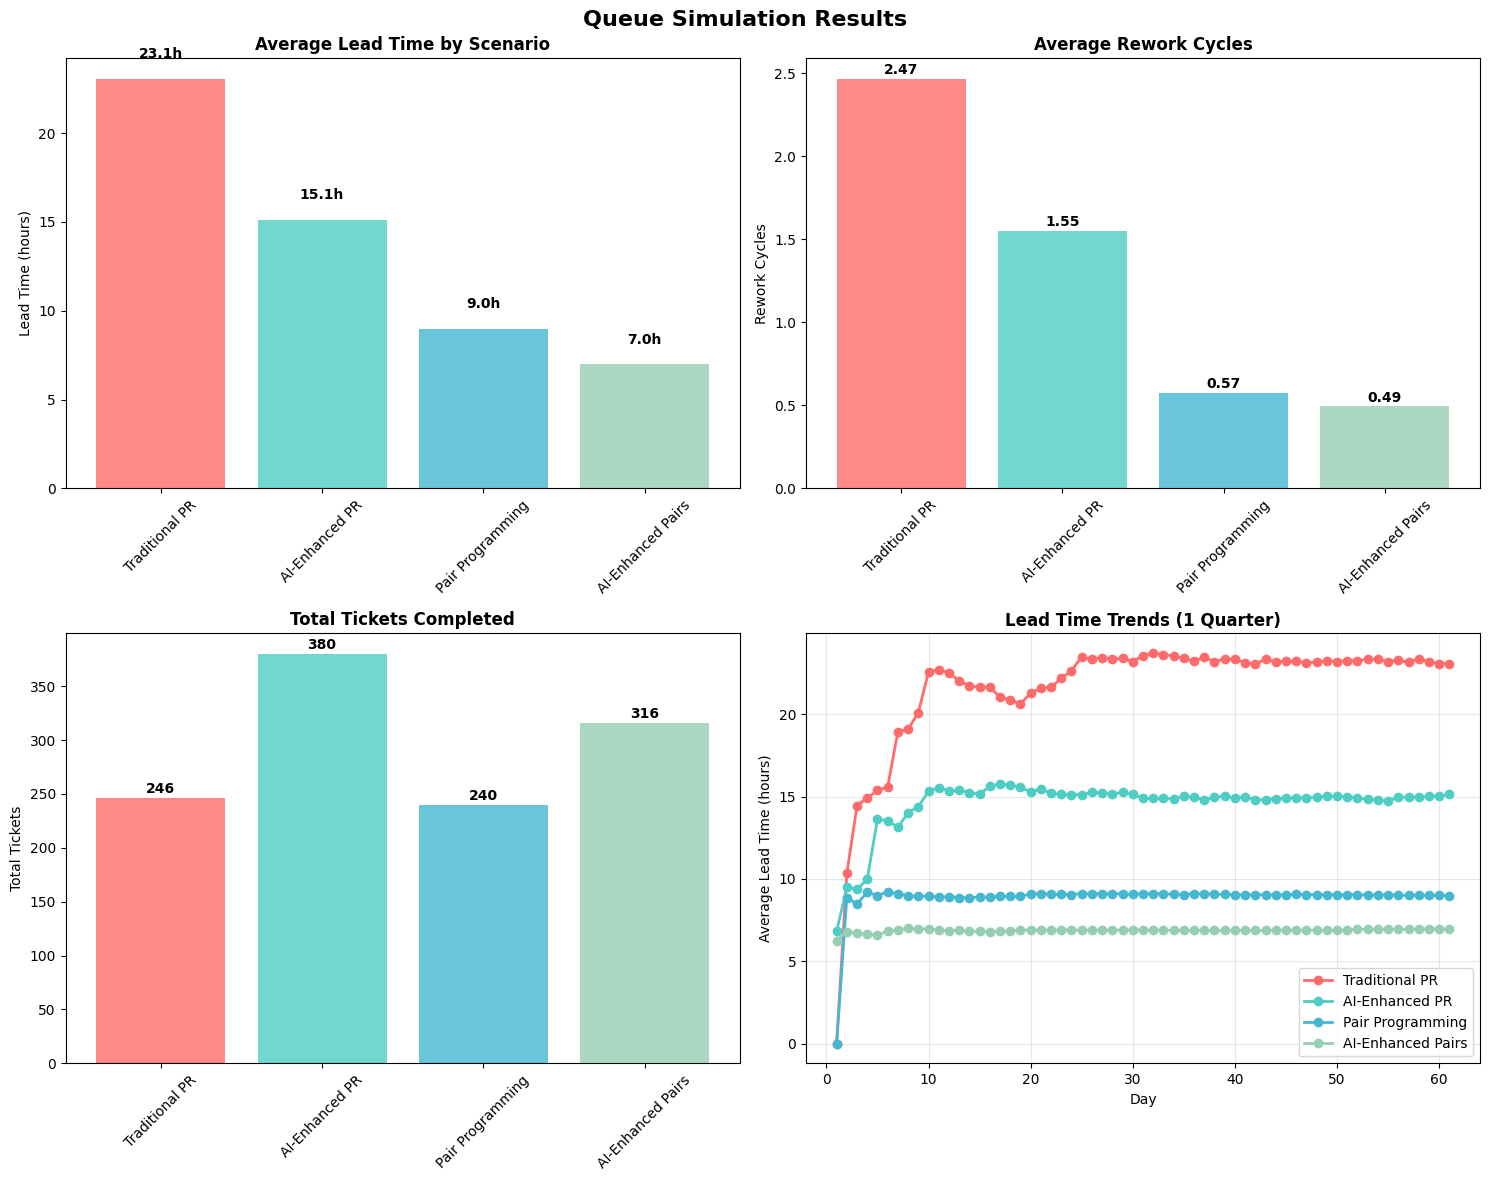


Visualization complete!


In [120]:
# Create results DataFrames
summary_df = pd.DataFrame(results)
daily_df = pd.DataFrame(detailed_data)

print("SIMULATION SUMMARY")
print("=" * 50)
display_cols = ['scenario', 'total_tickets', 'avg_lead_time_hours', 'avg_rework_cycles']
print(summary_df[display_cols].to_string(index=False))

# Visualization dashboard
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Queue Simulation Results', fontsize=16, fontweight='bold')

# 1. Lead Time Comparison
scenarios_names = summary_df['scenario']
lead_times = summary_df['avg_lead_time_hours']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

bars1 = ax1.bar(scenarios_names, lead_times, color=colors, alpha=0.8)
ax1.set_title('Average Lead Time by Scenario', fontweight='bold')
ax1.set_ylabel('Lead Time (hours)')
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, value in zip(bars1, lead_times):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{value:.1f}h', ha='center', va='bottom', fontweight='bold')

# 2. Rework Analysis
rework_cycles = summary_df['avg_rework_cycles']
bars2 = ax2.bar(scenarios_names, rework_cycles, color=colors, alpha=0.8)
ax2.set_title('Average Rework Cycles', fontweight='bold')
ax2.set_ylabel('Rework Cycles')
ax2.tick_params(axis='x', rotation=45)

for bar, value in zip(bars2, rework_cycles):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

# 3. Productivity (Tickets per Scenario)
total_tickets = summary_df['total_tickets']
bars3 = ax3.bar(scenarios_names, total_tickets, color=colors, alpha=0.8)
ax3.set_title('Total Tickets Completed', fontweight='bold')
ax3.set_ylabel('Total Tickets')
ax3.tick_params(axis='x', rotation=45)

for bar, value in zip(bars3, total_tickets):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
             f'{value}', ha='center', va='bottom', fontweight='bold')

# 4. Lead Time Trends Over Time
for i, scenario in enumerate(scenarios_names):
    scenario_data = daily_df[daily_df['scenario'] == scenario]
    if not scenario_data.empty:
        ax4.plot(scenario_data['day'], scenario_data['avg_lead_time_hours'], 
                marker='o', label=scenario, color=colors[i], linewidth=2)

ax4.set_title('Lead Time Trends (1 Quarter)', fontweight='bold')
ax4.set_xlabel('Day')
ax4.set_ylabel('Average Lead Time (hours)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nVisualization complete!")

## Lead Time Distribution Analysis

Statistical breakdown of lead time metrics showing the range and central tendency for each scenario.

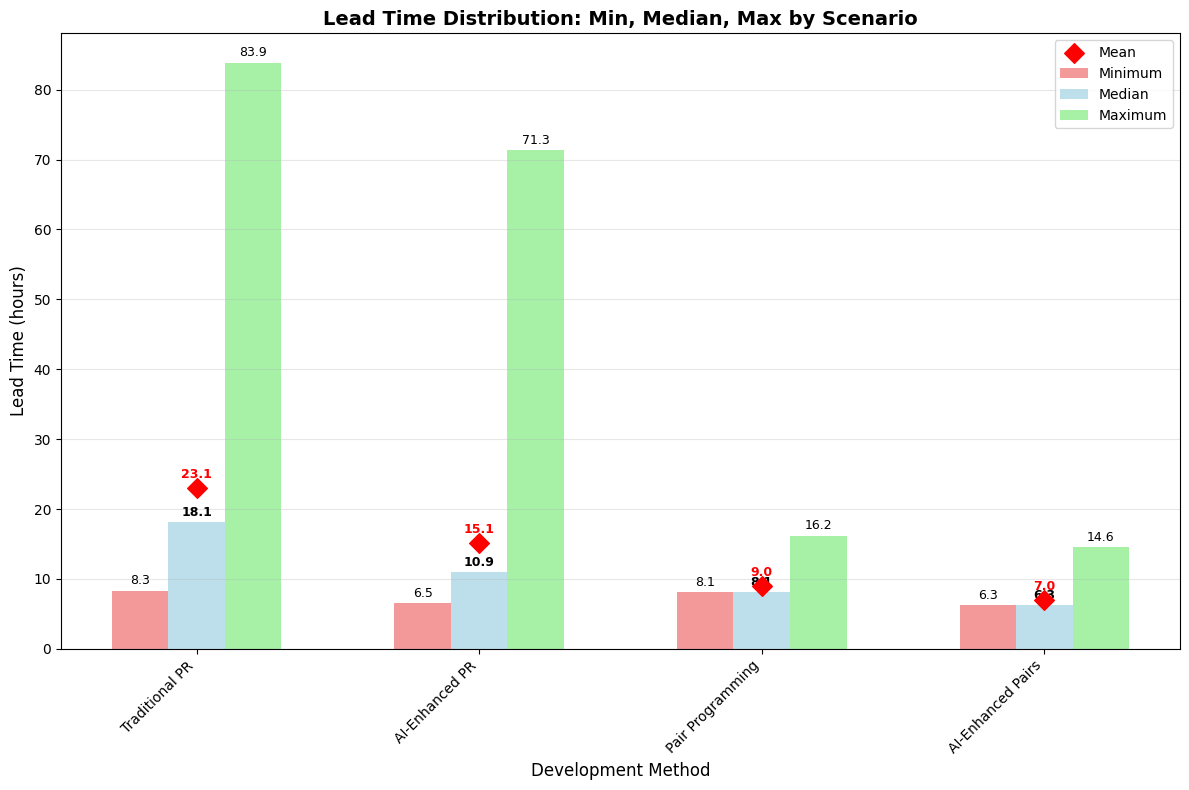


LEAD TIME DISTRIBUTION SUMMARY
         scenario  min  median  max  mean
   Traditional PR  8.3    18.1 83.9  23.1
   AI-Enhanced PR  6.5    10.9 71.3  15.1
 Pair Programming  8.1     8.1 16.2   9.0
AI-Enhanced Pairs  6.3     6.3 14.6   7.0

📊 KEY INSIGHTS:
--------------------
• Traditional PR:
  Range: 75.5h (Min: 8.3h, Max: 83.9h)
  Median: 18.1h, Mean: 23.1h
• AI-Enhanced PR:
  Range: 64.9h (Min: 6.5h, Max: 71.3h)
  Median: 10.9h, Mean: 15.1h
• Pair Programming:
  Range: 8.1h (Min: 8.1h, Max: 16.2h)
  Median: 8.1h, Mean: 9.0h
• AI-Enhanced Pairs:
  Range: 8.3h (Min: 6.3h, Max: 14.6h)
  Median: 6.3h, Mean: 7.0h


In [121]:
# Lead Time Distribution Statistics Chart
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Calculate statistics for each scenario
scenario_stats = []
for scenario in scenarios:
    if scenario.completed_tickets:
        times = [t.lead_time_hours for t in scenario.completed_tickets]
        stats = {
            'scenario': scenario.scenario_name,
            'min': np.min(times),
            'median': np.median(times),
            'max': np.max(times),
            'mean': np.mean(times)
        }
        scenario_stats.append(stats)

stats_df = pd.DataFrame(scenario_stats)

# Set up the bar positions
x = np.arange(len(stats_df))
width = 0.2
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

# Create grouped bars for min, median, max
bars1 = ax.bar(x - width, stats_df['min'], width, label='Minimum', color='lightcoral', alpha=0.8)
bars2 = ax.bar(x, stats_df['median'], width, label='Median', color='lightblue', alpha=0.8)
bars3 = ax.bar(x + width, stats_df['max'], width, label='Maximum', color='lightgreen', alpha=0.8)

# Add mean as scatter points
ax.scatter(x, stats_df['mean'], color='red', s=100, marker='D', label='Mean', zorder=5)

# Customize the chart
ax.set_title('Lead Time Distribution: Min, Median, Max by Scenario', fontweight='bold', fontsize=14)
ax.set_xlabel('Development Method', fontsize=12)
ax.set_ylabel('Lead Time (hours)', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(stats_df['scenario'], rotation=45, ha='right')
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar1, bar2, bar3) in enumerate(zip(bars1, bars2, bars3)):
    # Min values
    ax.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.5,
             f'{stats_df.iloc[i]["min"]:.1f}', ha='center', va='bottom', fontsize=9)
    # Median values
    ax.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.5,
             f'{stats_df.iloc[i]["median"]:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    # Max values
    ax.text(bar3.get_x() + bar3.get_width()/2, bar3.get_height() + 0.5,
             f'{stats_df.iloc[i]["max"]:.1f}', ha='center', va='bottom', fontsize=9)

# Add mean value labels
for i, mean_val in enumerate(stats_df['mean']):
    ax.text(x[i], mean_val + 1, f'{mean_val:.1f}', ha='center', va='bottom', 
            fontsize=9, fontweight='bold', color='red')

plt.tight_layout()
plt.show()

# Print summary table
print("\nLEAD TIME DISTRIBUTION SUMMARY")
print("=" * 60)
display_stats = stats_df.round(1)
print(display_stats.to_string(index=False))

print(f"\n📊 KEY INSIGHTS:")
print("-" * 20)
for _, row in stats_df.iterrows():
    range_val = row['max'] - row['min']
    print(f"• {row['scenario']}:")
    print(f"  Range: {range_val:.1f}h (Min: {row['min']:.1f}h, Max: {row['max']:.1f}h)")
    print(f"  Median: {row['median']:.1f}h, Mean: {row['mean']:.1f}h")

## Lead Time Analysis

Detailed analysis comparing lead times across different development methods.

C:\Users\micha\AppData\Local\Temp\ipykernel_52868\77651578.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax3.boxplot([lead_time_df[lead_time_df['Scenario'] == scenario]['Lead Time'].values


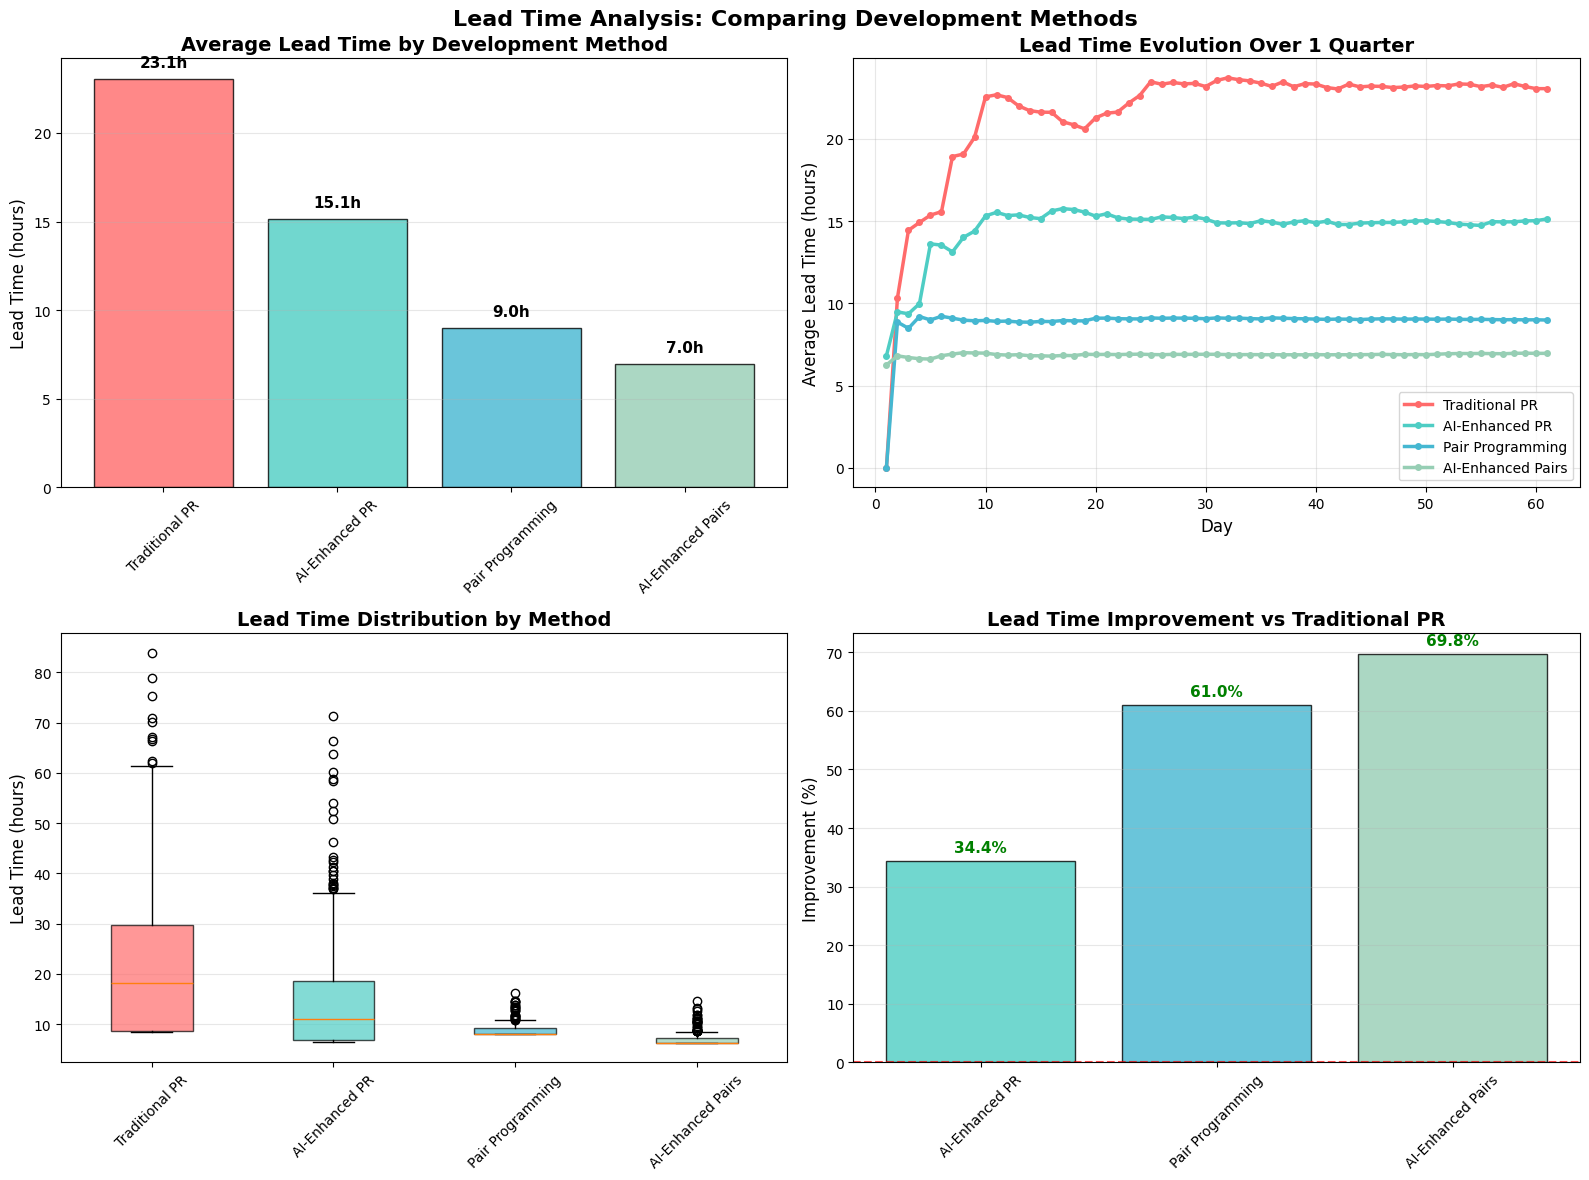

Lead time analysis complete!


In [122]:
# Lead Time Focused Analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Lead Time Analysis: Comparing Development Methods', fontsize=16, fontweight='bold')

# 1. Lead Time Bar Chart with Error Analysis
scenarios_names = summary_df['scenario']
lead_times = summary_df['avg_lead_time_hours']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

bars = ax1.bar(scenarios_names, lead_times, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_title('Average Lead Time by Development Method', fontweight='bold', fontsize=14)
ax1.set_ylabel('Lead Time (hours)', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, lead_times):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{value:.1f}h', ha='center', va='bottom', fontweight='bold', fontsize=11)

# 2. Lead Time Trends Over Time (Detailed)
for i, scenario in enumerate(scenarios_names):
    scenario_data = daily_df[daily_df['scenario'] == scenario]
    if not scenario_data.empty:
        ax2.plot(scenario_data['day'], scenario_data['avg_lead_time_hours'], 
                marker='o', label=scenario, color=colors[i], linewidth=2.5, markersize=4)

ax2.set_title('Lead Time Evolution Over 1 Quarter', fontweight='bold', fontsize=14)
ax2.set_xlabel('Day', fontsize=12)
ax2.set_ylabel('Average Lead Time (hours)', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# 3. Lead Time Distribution Comparison
lead_time_data = []
scenario_labels = []
for scenario in scenarios:
    if scenario.completed_tickets:
        times = [t.lead_time_hours for t in scenario.completed_tickets]
        lead_time_data.extend(times)
        scenario_labels.extend([scenario.scenario_name] * len(times))

if lead_time_data:
    lead_time_df = pd.DataFrame({'Lead Time': lead_time_data, 'Scenario': scenario_labels})
    
    # Box plot for distribution
    box_plot = ax3.boxplot([lead_time_df[lead_time_df['Scenario'] == scenario]['Lead Time'].values 
                           for scenario in scenarios_names], 
                          labels=scenarios_names, patch_artist=True)
    
    # Color the boxes
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax3.set_title('Lead Time Distribution by Method', fontweight='bold', fontsize=14)
    ax3.set_ylabel('Lead Time (hours)', fontsize=12)
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(axis='y', alpha=0.3)

# 4. Lead Time Improvement Analysis
baseline_lead_time = summary_df[summary_df['scenario'] == 'Traditional PR']['avg_lead_time_hours'].iloc[0]
improvements = []
improvement_labels = []

for _, row in summary_df.iterrows():
    if row['scenario'] != 'Traditional PR':
        improvement = ((baseline_lead_time - row['avg_lead_time_hours']) / baseline_lead_time) * 100
        improvements.append(improvement)
        improvement_labels.append(row['scenario'])

if improvements:
    colors_subset = colors[1:]  # Exclude traditional PR color
    bars4 = ax4.bar(improvement_labels, improvements, color=colors_subset, alpha=0.8, edgecolor='black', linewidth=1)
    ax4.set_title('Lead Time Improvement vs Traditional PR', fontweight='bold', fontsize=14)
    ax4.set_ylabel('Improvement (%)', fontsize=12)
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(axis='y', alpha=0.3)
    ax4.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    
    # Add value labels
    for bar, value in zip(bars4, improvements):
        color = 'green' if value > 0 else 'red'
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (1 if value > 0 else -3),
                 f'{value:.1f}%', ha='center', va='bottom' if value > 0 else 'top', 
                 fontweight='bold', color=color, fontsize=11)

plt.tight_layout()
plt.show()

print("Lead time analysis complete!")

## Lead Time Summary Statistics

Statistical summary of lead time performance across all methods.

In [123]:
# Lead Time Statistics Table
print("LEAD TIME ANALYSIS SUMMARY")
print("=" * 60)

# Create detailed statistics
lead_time_stats = []
for scenario in scenarios:
    if scenario.completed_tickets:
        times = [t.lead_time_hours for t in scenario.completed_tickets]
        stats = {
            'Scenario': scenario.scenario_name,
            'Mean (hours)': np.mean(times),
            'Median (hours)': np.median(times),
            'Std Dev (hours)': np.std(times),
            'Min (hours)': np.min(times),
            'Max (hours)': np.max(times),
            'Total Tickets': len(times)
        }
        lead_time_stats.append(stats)

stats_df = pd.DataFrame(lead_time_stats)
print(stats_df.round(2).to_string(index=False))

# Performance ranking
print(f"\n📊 LEAD TIME PERFORMANCE RANKING:")
print("-" * 40)
ranked_scenarios = stats_df.sort_values('Mean (hours)')
for i, (_, row) in enumerate(ranked_scenarios.iterrows(), 1):
    print(f"{i}. {row['Scenario']}: {row['Mean (hours)']:.1f} hours")

# Key insights
traditional_mean = stats_df[stats_df['Scenario'] == 'Traditional PR']['Mean (hours)'].iloc[0]
print(f"\n🎯 KEY INSIGHTS:")
print("-" * 20)

for _, row in stats_df.iterrows():
    if row['Scenario'] != 'Traditional PR':
        improvement = ((traditional_mean - row['Mean (hours)']) / traditional_mean) * 100
        direction = "faster" if improvement > 0 else "slower"
        print(f"• {row['Scenario']}: {abs(improvement):.1f}% {direction} than Traditional PR")

print(f"\n⚡ BEST PERFORMING METHOD: {ranked_scenarios.iloc[0]['Scenario']}")
print(f"   Average lead time: {ranked_scenarios.iloc[0]['Mean (hours)']:.1f} hours")

print("\nLead time statistical analysis complete!")

LEAD TIME ANALYSIS SUMMARY
         Scenario  Mean (hours)  Median (hours)  Std Dev (hours)  Min (hours)  Max (hours)  Total Tickets
   Traditional PR         23.06           18.08            16.58         8.33        83.87            246
   AI-Enhanced PR         15.13           10.94            11.48         6.49        71.35            380
 Pair Programming          8.99            8.10             1.49         8.10        16.16            240
AI-Enhanced Pairs          6.97            6.25             1.33         6.25        14.56            316

📊 LEAD TIME PERFORMANCE RANKING:
----------------------------------------
1. AI-Enhanced Pairs: 7.0 hours
2. Pair Programming: 9.0 hours
3. AI-Enhanced PR: 15.1 hours
4. Traditional PR: 23.1 hours

🎯 KEY INSIGHTS:
--------------------
• AI-Enhanced PR: 34.4% faster than Traditional PR
• Pair Programming: 61.0% faster than Traditional PR
• AI-Enhanced Pairs: 69.8% faster than Traditional PR

⚡ BEST PERFORMING METHOD: AI-Enhanced Pairs
   A

## Export Results

Save the simulation data for further analysis.

In [124]:
# Export results
summary_df.to_csv('simulation_summary.csv', index=False)
daily_df.to_csv('daily_metrics.csv', index=False)

print("Simulation data exported:")
print("  • simulation_summary.csv")
print("  • daily_metrics.csv")

# Display final summary
print("\nFINAL SUMMARY")
print("=" * 20)
for _, row in summary_df.iterrows():
    print(f"{row['scenario']}:")
    print(f"  Lead Time: {row['avg_lead_time_hours']:.1f} hours")
    print(f"  Tickets: {row['total_tickets']}")
    print(f"  Rework Cycles: {row['avg_rework_cycles']:.2f}")
    print()

print("Queue simulation complete!")

Simulation data exported:
  • simulation_summary.csv
  • daily_metrics.csv

FINAL SUMMARY
Traditional PR:
  Lead Time: 23.1 hours
  Tickets: 246
  Rework Cycles: 2.47

AI-Enhanced PR:
  Lead Time: 15.1 hours
  Tickets: 380
  Rework Cycles: 1.55

Pair Programming:
  Lead Time: 9.0 hours
  Tickets: 240
  Rework Cycles: 0.57

AI-Enhanced Pairs:
  Lead Time: 7.0 hours
  Tickets: 316
  Rework Cycles: 0.49

Queue simulation complete!
